In [1]:
# yellowbrick.features.histogram
# Implementations of histogram with vertical lines to help with balanced binning.
#
# Author:   Juan L. Kehoe (juanluo2008@gmail.com)
# Created:  Tue Mar 13 19:50:54 2018 -0400
#
# Copyright (C) 2018 District Data Labs
# For license information, see LICENSE.txt
#
# ID: histogram.py

"""
Implements histogram with vertical lines to help with balanced binning.
"""

##########################################################################
## Imports
##########################################################################
import warnings
import matplotlib.pyplot as plt
import numpy as np

from yellowbrick.features.base import FeatureVisualizer
from yellowbrick.exceptions import YellowbrickValueError
from yellowbrick.utils import is_dataframe

##########################################################################
## Balanced Binning Reference
##########################################################################

class BalancedBinningReference(FeatureVisualizer):
    """
    BalancedBinningReference allows to generate a histogram with vertical lines
    showing the recommended value point to bin your data so they can be evenly
    distributed in each bin.

    Parameters
    ----------
    ax: matplotlib Axes, default: None
        This is inherited from FeatureVisualizer and is defined within
        BalancedBinningReference.
    feature: string, default: None
        The name of the X variable
        If a DataFrame is passed to fit and feature is None, feature
        is selected as the column of the DataFrame.  There must be only
        one column in the DataFrame.
    target: string, default: None
        The name of the Y variable
        If target is None and a y value is passed to fit then the target
        is selected from the target vector.
    size: float, default: 600
        Size of each side of the figure in pixels
    ratio: float, default: 5
        Ratio of joint axis size to the x and y axes height
    space: float, default: 0.2
        Space between the joint axis and the x and y axes
    kwargs : dict
        Keyword arguments that are passed to the base class and may influence
        the visualization as defined in other Visualizers.

    Examples
    --------
    >>> visualizer = BalancedBinningReference()
    >>> visualizer.fit(X)
    >>> visualizer.poof()


    Notes
    -----
    These parameters can be influenced later on in the visualization
    process, but can and should be set as early as possible.
    """

    def __init__(self, ax=None, feature=None, target='Counts', bins=4,
                 x_args=None, size=600, ratio=5, space=.2, **kwargs):

        super(BalancedBinningReference, self).__init__(ax, **kwargs)

        self.feature = feature
        self.target = target
        self.bins = bins
        self.x_args = x_args
        self.size = (size, size)
        self.ratio = ratio
        self.space = space

    # decide how many bins do you want for your data
    def get_vline_value(self, X):
        """
        Gets the values to draw vertical lines on histogram
        to help balanced binning based on number of bins the
        user wants
        Parameters
        ----------
        X : ndarray or DataFrame of shape n x 1
            A matrix of n instances with 1 feature
        bin: number of bins the user wants, default=4
        """
        # get the number of samples
        samples, = X.shape

        # get the index for retrieving values for the bins
        index = int(round(samples/self.bins))

        # sort the samples from low to high
        sorted_X = np.sort(X)

        # a list to store the values for the binning reference
        values = []

        # get the values for the binning reference
        for i in range(0, (self.bins-1)):
            value = sorted_X[index * (i + 1)]
            values.append(value)

        return values

    def draw(self, X, **kwargs):
        """
        Draws a histogram with the reference value for binning as vetical lines
        Parameters
        ----------
        X : ndarray or DataFrame of shape n x 1
            A matrix of n instances with 1 feature
        """

        # draw the histogram
        self.ax.hist(X, bins=50, color="#6897bb", **kwargs)

        # add vetical line with binning reference values
        self.ax.vlines(self.get_vline_value(X), 0, 1, transform=self.ax.get_xaxis_transform(), colors='r')
        print("The binning reference values are:", self.get_vline_value(X))

    def fit(self, X, **kwargs):
        """
        Sets up X for the histogram and checks to
        ensure that X is of the correct data type
        Fit calls draw
        Parameters
        ----------
        X : ndarray or DataFrame of shape n x 1
            A matrix of n instances with 1 feature
        kwargs: dict
            keyword arguments passed to Scikit-Learn API.
        """

        #throw an error if X has more than 1 column
        if is_dataframe(X):
            nrows, ncols = X.shape

            if ncols > 1:
                raise YellowbrickValueError((
                    "X needs to be an ndarray or DataFrame with one feature, "
                    "please select one feature from the DataFrame"
                ))

        # Handle the feature name if it is None.
        if self.feature is None:

            # If X is a data frame, get the columns off it.
            if is_dataframe(X):
                self.feature = X.columns

            else:
                self.feature = ['x']

        self.draw(X)
        return self


    def poof(self, **kwargs):
        """
        Creates the labels for the feature and target variables
        """

        self.ax.set_xlabel(self.feature)
        self.ax.set_ylabel(self.target)
        self.finalize(**kwargs)

    def finalize(self, **kwargs):
        """
        Finalize executes any subclass-specific axes finalization steps.
        The user calls poof and poof calls finalize.
        Parameters
        ----------
        kwargs: generic keyword arguments.
        """

        plt.setp(self.ax.get_xticklabels(), visible=True)
        plt.setp(self.ax.get_yticklabels(), visible=True)


In [15]:
# generate 3 set of data with norm, right-skew and left-skew distribution
from scipy.stats import skewnorm
norm = skewnorm.rvs(0, size=1000)
right_skew = skewnorm.rvs(-5, size=1000)
left_skew = skewnorm.rvs(5, size=1000)

The binning reference values are: [-0.6326099733459714, 0.01222456657228109, 0.6753151977252412]


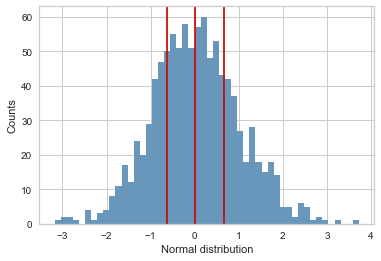

In [16]:
# get the reference value for the binning point for normal distribution
visualizer = BalancedBinningReference(feature="Normal distribution")
visualizer.fit(norm)
visualizer.poof()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

<Container object of 5 artists>

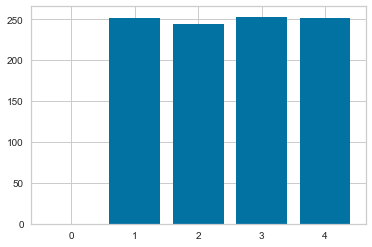

In [64]:
# bin the data based on the reference

bins = np.array([-4, -0.63, 0, 0.67, 4])
inds = np.digitize(norm, bins)
bincounts = np.bincount(inds)
plt.bar(np.arange(5), bincounts)

<Container object of 5 artists>

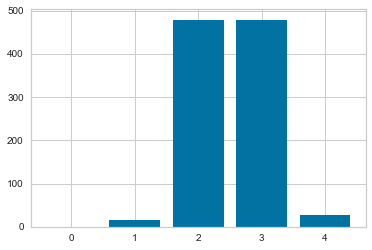

In [62]:
# bin the data without the reference

bins = np.array([-4, -2, 0, 2, 4])
inds = np.digitize(norm, bins)
bincounts = np.bincount(inds)
plt.bar(np.arange(5), bincounts)

The binning reference values are: [-0.8809547817059689, -0.4084565099084327, 0.016196798029483355, 0.44602204781907623, 0.9782790184681378]


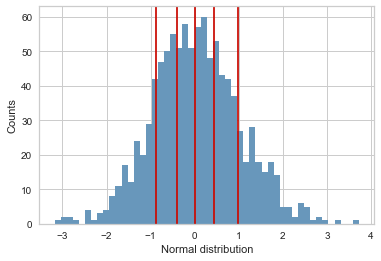

In [17]:
# use 6 bins
visualizer = BalancedBinningReference(feature="Normal distribution", bins=6)
visualizer.fit(norm)
visualizer.poof()

<Container object of 7 artists>

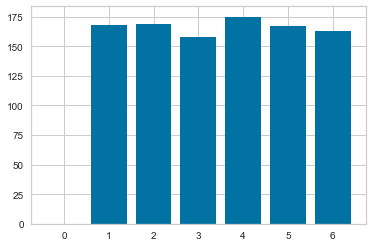

In [65]:
# bin the data based on the reference

bins = np.array([-4, -0.88, -0.4, 0, 0.45, 0.98, 4])
inds = np.digitize(norm, bins)
bincounts = np.bincount(inds)
plt.bar(np.arange(7), bincounts)

<Container object of 7 artists>

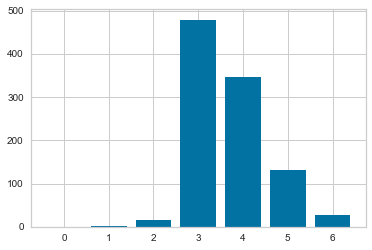

In [63]:
# bin the data without the reference

bins = np.array([-4, -3, -2, 0, 1, 2, 4])
inds = np.digitize(norm, bins)
bincounts = np.bincount(inds)
plt.bar(np.arange(7), bincounts)

The binning reference values are: [-1.138553806516517, -0.7010117989998319, -0.2745606219570957]


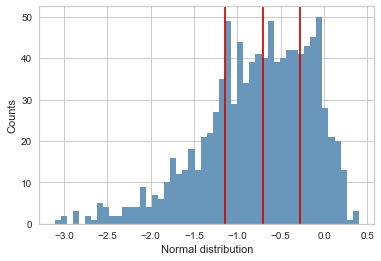

In [18]:
# get the reference value for the binning point for righ-skewed distribution
visualizer = BalancedBinningReference(feature="Right-skewed distribution")
visualizer.fit(right_skew)
visualizer.poof()

<Container object of 5 artists>

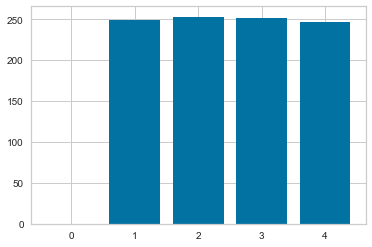

In [60]:
# bin the data based on the reference

bins = np.array([-4, -1.14, -0.7, -0.27, 0.5])
inds = np.digitize(right_skew, bins)
bincounts = np.bincount(inds)
plt.bar(np.arange(5), bincounts)

<Container object of 5 artists>

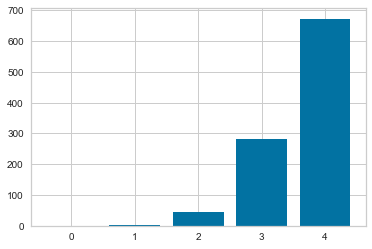

In [66]:
# bin the data without the reference

bins = np.array([-4, -3, -2, -1, 0.5])
inds = np.digitize(right_skew, bins)
bincounts = np.bincount(inds)
plt.bar(np.arange(5), bincounts)

The binning reference values are: [0.32766557777193045, 0.7048784144423138, 1.2255349029328841]


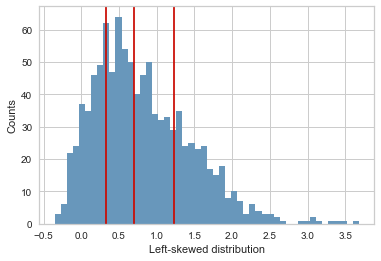

In [19]:
# get the reference value for the binning point for left-skewed distribution
visualizer = BalancedBinningReference(feature="Left-skewed distribution")
visualizer.fit(left_skew)
visualizer.poof()

<Container object of 5 artists>

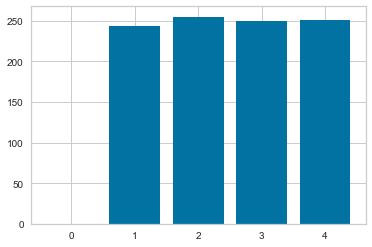

In [61]:
# bin the data based on the reference

bins = np.array([-0.5, 0.32, 0.7, 1.22, 4])
inds = np.digitize(left_skew, bins)
bincounts = np.bincount(inds)
plt.bar(np.arange(5), bincounts)

<Container object of 5 artists>

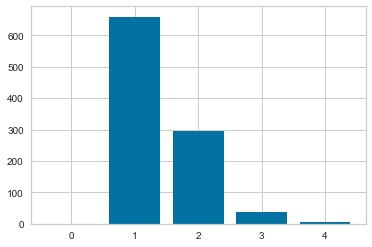

In [67]:
# bin the data without the reference

bins = np.array([-0.5, 1, 2, 3, 4])
inds = np.digitize(left_skew, bins)
bincounts = np.bincount(inds)
plt.bar(np.arange(5), bincounts)